In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F


plt.rcParams["savefig.bbox"] = "tight"


def plot(imgs, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0])
    _, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            img = F.to_pil_image(img.to("cpu"))
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    plt.tight_layout()

/home/s0001638/miniconda3/lib/python3.9/site-packages/torchvision/io/video.py:161: UserWarning: The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.
  warnings.warn("The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.")


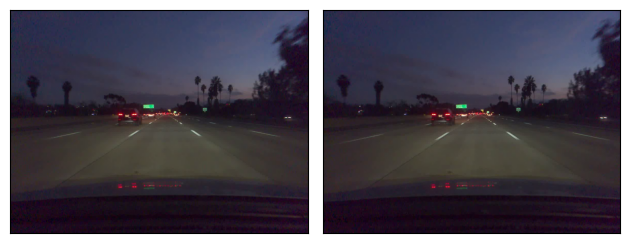

In [2]:
from torchvision.io import read_video
video_path = "./calib_challenge_valdag_fork/labeled/0.avi"
frames, _, _ = read_video(str(video_path), output_format="TCHW")

img1_batch = torch.stack([frames[0], frames[1]])
img2_batch = torch.stack([frames[1], frames[2]])

plot(img1_batch)

/home/s0001638/miniconda3/lib/python3.9/site-packages/torchvision/io/video.py:161: UserWarning: The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.
  warnings.warn("The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.")


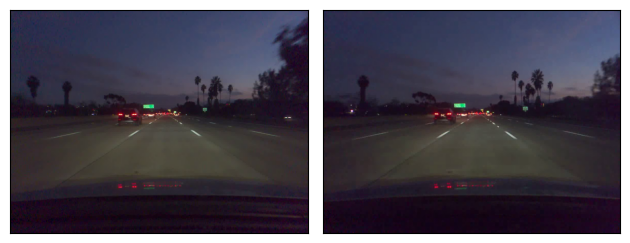

In [2]:
from torchvision.io import read_video
video_path = "./calib_challenge_valdag_fork/labeled/0.avi"
frames, _, _ = read_video(str(video_path), output_format="TCHW")

img1_batch = torch.stack([frames[0], frames[10]])
img2_batch = torch.stack([frames[10], frames[20]])

plot(img1_batch)

In [3]:
from torchvision.models.optical_flow import Raft_Small_Weights

weights = Raft_Small_Weights.DEFAULT
transforms = weights.transforms()


def preprocess(img1_batch, img2_batch):
    img1_batch = F.resize(img1_batch, size=[520, 960], antialias=False)
    img2_batch = F.resize(img2_batch, size=[520, 960], antialias=False)
    return transforms(img1_batch, img2_batch)


img1_batch, img2_batch = preprocess(img1_batch, img2_batch)

print(f"shape = {img1_batch.shape}, dtype = {img1_batch.dtype}")

shape = torch.Size([2, 3, 520, 960]), dtype = torch.float32


In [4]:
from torchvision.models.optical_flow import raft_small

# If you can, run this example on a GPU, it will be a lot faster.
device = "cuda" if torch.cuda.is_available() else "cpu"

model = raft_small(weights=Raft_Small_Weights.DEFAULT, progress=False).to(device)
model = model.eval()

list_of_flows = model(img1_batch.to(device), img2_batch.to(device))
print(f"type = {type(list_of_flows)}")
print(f"length = {len(list_of_flows)} = number of iterations of the model")

type = <class 'list'>
length = 12 = number of iterations of the model


In [5]:
predicted_flows = list_of_flows[-1]
print(f"dtype = {predicted_flows.dtype}")
print(f"shape = {predicted_flows.shape} = (N, 2, H, W)")
print(f"min = {predicted_flows.min()}, max = {predicted_flows.max()}")
print(f"len predicted_flows = {len(predicted_flows)}")
print(f"video shape = {frames.shape}")

dtype = torch.float32
shape = torch.Size([2, 2, 520, 960]) = (N, 2, H, W)
min = -83.10954284667969, max = 50.545310974121094
len predicted_flows = 2
video shape = torch.Size([1200, 3, 874, 1164])


In [6]:
model

RAFT(
  (feature_encoder): FeatureEncoder(
    (convnormrelu): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
      (1): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): ReLU(inplace=True)
    )
    (layer1): Sequential(
      (0): BottleneckBlock(
        (convnormrelu1): Conv2dNormActivation(
          (0): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (1): InstanceNorm2d(8, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
          (2): ReLU(inplace=True)
        )
        (convnormrelu2): Conv2dNormActivation(
          (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): InstanceNorm2d(8, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
          (2): ReLU(inplace=True)
        )
        (convnormrelu3): Conv2dNormActivation(
          (0): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (1): Inst

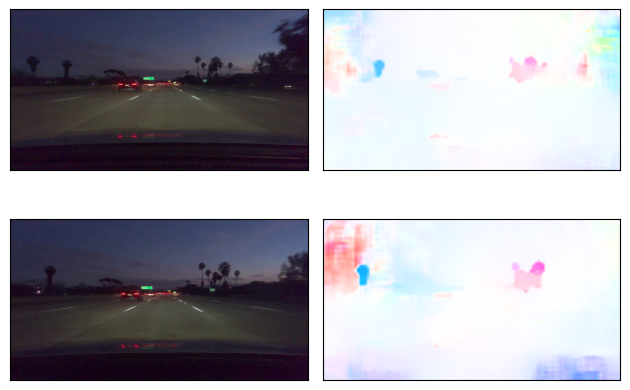

In [7]:
from torchvision.utils import flow_to_image

flow_imgs = flow_to_image(predicted_flows)

# The images have been mapped into [-1, 1] but for plotting we want them in [0, 1]
img1_batch = [(img1 + 1) / 2 for img1 in img1_batch]

grid = [[img1, flow_img] for (img1, flow_img) in zip(img1_batch, flow_imgs)]
plot(grid)

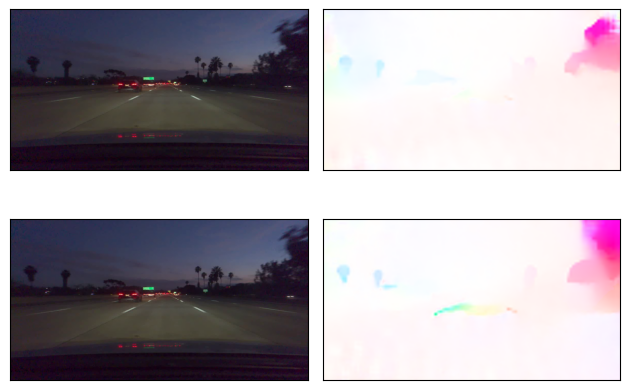

In [7]:
from torchvision.utils import flow_to_image

flow_imgs = flow_to_image(predicted_flows)

# The images have been mapped into [-1, 1] but for plotting we want them in [0, 1]
img1_batch = [(img1 + 1) / 2 for img1 in img1_batch]

grid = [[img1, flow_img] for (img1, flow_img) in zip(img1_batch, flow_imgs)]
plot(grid)

In [8]:
predicted_flows.shape

torch.Size([2, 2, 520, 960])